In [1]:
from numpy.random import seed
seed(1)
import tensorflow
tensorflow.random.set_seed(2)

In [2]:
#Import Stuff here

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

import tensorflow.keras as keras
from tensorflow import Tensor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, ReLU, Conv2D, MaxPooling2D, Flatten, GlobalAveragePooling2D 
from tensorflow.keras.layers import DepthwiseConv2D, BatchNormalization, Add, Input, AveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import numpy as np
from tensorflow.keras.utils import plot_model
from focal_loss import SparseCategoricalFocalLoss
from keras.models import load_model

In [3]:
#creates a Image Generator from the directories and scales the images by dividing by 255. Also changes the images sizes to 256x256

def load_data(train_folder = 'data/train/'):

    datagen = ImageDataGenerator(rescale = 1/255)
    
    train_it = datagen.flow_from_directory (train_folder, target_size = (256, 256), 
                                            class_mode = 'sparse', color_mode="rgb", batch_size=64, seed = 1)
    
    val_it = datagen.flow_from_directory ('data/validation/', target_size = (256, 256), 
                                            class_mode = 'sparse', color_mode="rgb", batch_size=64, seed = 1)
    
    test_it = datagen.flow_from_directory ('data/test/', target_size = (256, 256), 
                                            class_mode = 'sparse', color_mode="rgb", batch_size=64, seed = 1,  shuffle=False)
    
    return train_it, val_it, test_it

train_it, val_it, test_it = load_data()

Found 6800 images belonging to 17 classes.
Found 1700 images belonging to 17 classes.
Found 1700 images belonging to 17 classes.


In [4]:
batchX, batchy = train_it.next()
print('Batch shape=%s, min=%.3f, max=%.3f' % (batchX.shape, batchX.min(), batchX.max()))

Batch shape=(64, 256, 256, 3), min=0.000, max=1.000


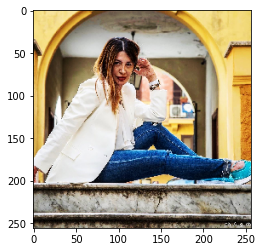

In [5]:
plt.imshow(batchX[0])

In [6]:
batchy[63]

11.0

In [7]:
def res_block(x: Tensor, filters: int, kernel_size: int, stride : int):
    
    output1 = Conv2D (filters, kernel_size = kernel_size, strides = stride, padding = 'same')(x)
 #   output1 = BatchNormalization()(output1)
    
    output1 = Conv2D (filters, kernel_size = kernel_size, padding = 'same')(output1)
    
    if stride == 2:
        x = Conv2D (filters, kernel_size = kernel_size, strides = 2, padding = 'same')(x)
    
    output_added = Add()([x, output1])
    output_added = ReLU() (output_added)
    output_added = BatchNormalization()(output_added)
    
    return output_added

In [8]:
def build_model():
    # TODO: build the model, 
    
    inputs = Input(shape=(256, 256, 3, ))    
  
    x = BatchNormalization()(inputs)
    
    x = Conv2D (64, kernel_size = 3, strides = 1, activation = 'relu', padding = 'same')(x)
    
    x = res_block(x, filters = 64, kernel_size = 3, stride = 1)
    x = res_block(x, filters = 64, kernel_size = 3, stride = 1) 
    
    x = res_block(x, filters = 128, kernel_size = 3, stride = 2)
    x = res_block(x, filters = 128, kernel_size = 3, stride = 1)
 
    
    x = res_block(x, filters = 256, kernel_size = 3, stride = 2)
    x = res_block(x, filters = 256, kernel_size = 3, stride = 1)

    x = res_block(x, filters = 512, kernel_size = 3, stride = 2)
    x = res_block(x, filters = 512, kernel_size = 3, stride = 1)
    
    
    x = Conv2D(128, kernel_size= 3, activation = 'relu', padding='same')(x) #added back in
    x = BatchNormalization()(x)
    
    x = AveragePooling2D(4)(x) 
    x = Flatten()(x)

    
    x = Dense(64, activation = 'relu')(x)    
    my_output = Dropout (0.2)(x)
    
    probs = Dense(17, activation = 'softmax')(my_output)

    model = keras.Model(inputs= inputs, outputs=probs)
      
    model.summary()

    return model

model = build_model()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 3)  12         ['input_1[0][0]']                
 alization)                                                                                       
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  1792        ['batch_normalization[0][0]']    
                                )                                                             

In [9]:
def compile_model(model):
    # TODO: compile the model

    model.compile(optimizer = keras.optimizers.Adam(learning_rate = 0.0001),
              loss=keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

    return model

def train_model(model, train_it, val_it):
    # TODO: train the model
    callback = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights= True)
    
    history = model.fit(train_it, epochs = 50, steps_per_epoch = 107, verbose = 2, 
                        validation_data= val_it, validation_steps = 27, callbacks=[callback])
    return model, history


model = compile_model(model)

model, history = train_model(model, train_it, val_it)

len(history.history['loss'])  #


Epoch 1/50
107/107 - 117s - loss: 1.5612 - accuracy: 0.5196 - val_loss: 8.1866 - val_accuracy: 0.0588 - 117s/epoch - 1s/step
Epoch 2/50
107/107 - 95s - loss: 0.7931 - accuracy: 0.7453 - val_loss: 7.2920 - val_accuracy: 0.0924 - 95s/epoch - 891ms/step
Epoch 3/50
107/107 - 95s - loss: 0.5728 - accuracy: 0.8154 - val_loss: 5.4901 - val_accuracy: 0.1735 - 95s/epoch - 890ms/step
Epoch 4/50
107/107 - 95s - loss: 0.4508 - accuracy: 0.8512 - val_loss: 2.0716 - val_accuracy: 0.4682 - 95s/epoch - 887ms/step
Epoch 5/50
107/107 - 96s - loss: 0.3645 - accuracy: 0.8793 - val_loss: 1.1642 - val_accuracy: 0.6771 - 96s/epoch - 898ms/step
Epoch 6/50
107/107 - 107s - loss: 0.3461 - accuracy: 0.8841 - val_loss: 0.5762 - val_accuracy: 0.8241 - 107s/epoch - 1s/step
Epoch 7/50
107/107 - 97s - loss: 0.2647 - accuracy: 0.9129 - val_loss: 0.4931 - val_accuracy: 0.8529 - 97s/epoch - 910ms/step
Epoch 8/50
107/107 - 95s - loss: 0.2518 - accuracy: 0.9171 - val_loss: 0.5928 - val_accuracy: 0.8465 - 95s/epoch - 887ms

12

In [10]:
def eval_model(model, test_it):
    # TODO: evaluate the model

    test_loss, test_accuracy = model.evaluate (test_it, steps = 27)

    return test_loss, test_accuracy

test_loss, test_accuracy = eval_model(model, test_it)

27/27 [==============================] - 22s 802ms/step - loss: 0.4317 - accuracy: 0.8676


In [11]:
test_it.reset()
preds = model.predict(test_it, steps = 27)

In [12]:
y_predict = np.argmax(preds,axis=1)

In [13]:
print(classification_report(test_it.classes, y_predict, target_names=test_it.class_indices))

              precision    recall  f1-score   support

        1977       0.94      0.98      0.96       100
       Amaro       0.77      0.83      0.80       100
     Brannan       0.83      0.95      0.88       100
   Clarendon       0.84      0.75      0.79       100
     Gingham       0.83      1.00      0.90       100
       He-Fe       0.93      0.85      0.89       100
      Hudson       0.92      0.90      0.91       100
       Lo-Fi       0.73      0.82      0.77       100
     Mayfair       0.79      0.95      0.86       100
   Nashville       0.99      0.85      0.91       100
    Original       0.69      0.60      0.64       100
    Perpetua       0.93      0.81      0.87       100
       Sutro       0.89      0.97      0.93       100
     Toaster       0.98      0.93      0.95       100
    Valencia       0.83      0.68      0.75       100
      Willow       0.98      0.98      0.98       100
     X-ProII       0.96      0.90      0.93       100

    accuracy              

In [19]:
error_count = 0

for x in range (0,len(y_predict)):
    if y_predict[x] != test_it.classes[x]:
        error_count += 1
        
error_count

225

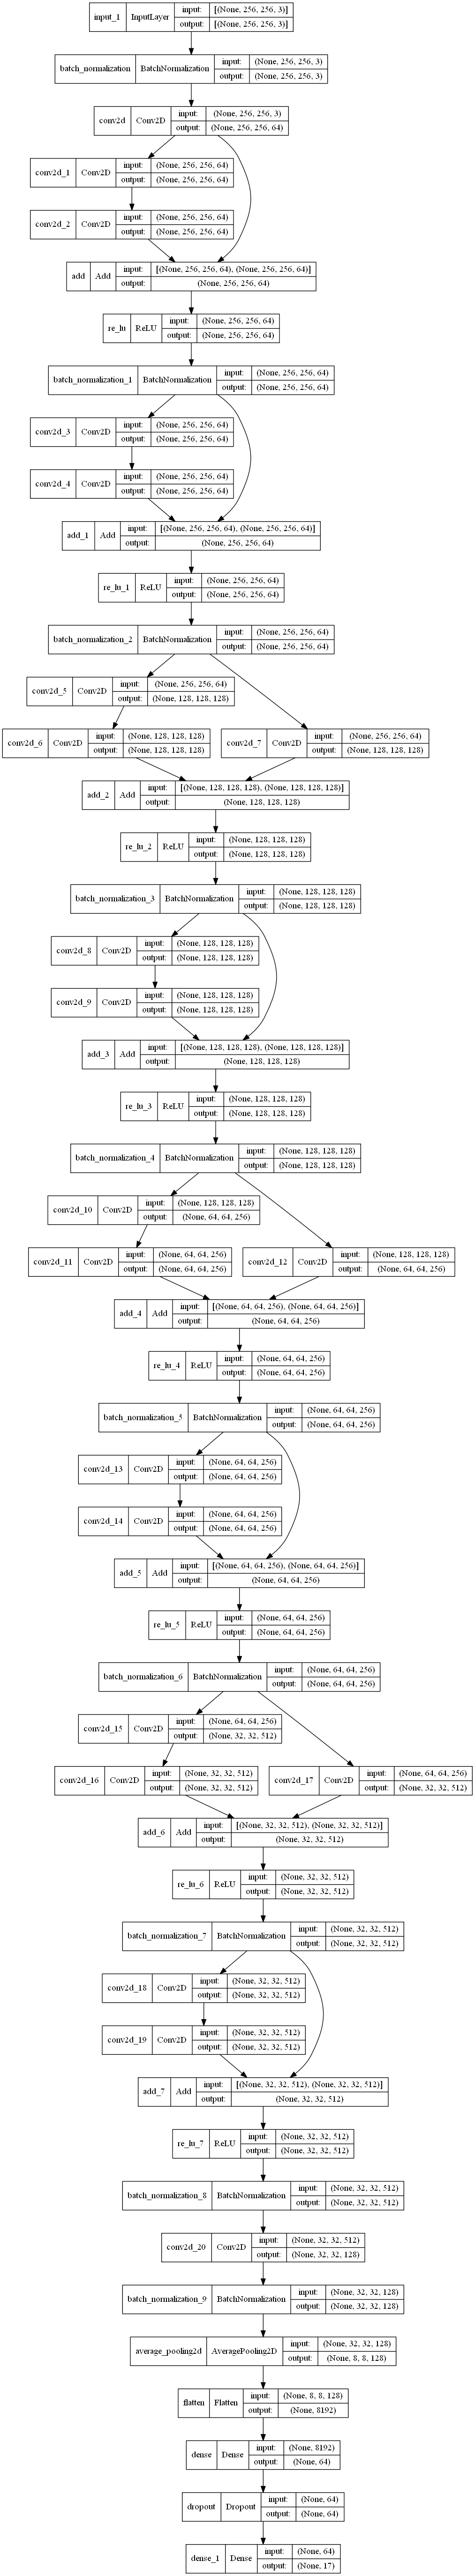

In [15]:
plot_model (model, 'model.png', show_shapes=True)

In [17]:
model.save('ResNet_original_87_final.h5', overwrite=True,
    include_optimizer=True)